<a href="https://colab.research.google.com/github/sam134-eng/ImplementingReinforcement-learning-on-Algorithmic-Trading/blob/main/Copy_of_RL__Trading_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install gym-anytrading
!pip install stable-baselines3

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
#Stable Baseline3 for RL
from stable_baselines3 import PPO , DQN
from stable_baselines3.common.vec_env import DummyVecEnv
import gym
import gym_anytrading

from gym_anytrading.envs import StocksEnv
#Evaluation metrics
#Computing annualized Sharpe ratio
def sharpe_ratio(returns, risk_free=0.0, annual_factor=252):

    excess_ret = returns - risk_free
    # sample std with ddof=1 is more statistically correct
    vol = np.std(excess_ret, ddof=1)

    if vol == 0:
        return np.nan   # no variability, Sharpe undefined
    return (np.mean(excess_ret) / vol) * np.sqrt(annual_factor)
#Computing Maximum Drawdown
def max_drawdown(equity_curve):
    roll_max= np.maximum.accumulate(equity_curve)
    drawdown= (equity_curve-roll_max)/ roll_max
    return drawdown.min()

from dataclasses import dataclass

@dataclass
class RegimeSplit:
    """
    Defines regime-aware time slices for Train / Validation / Test.
    """
    train_start: str = "2012-01-01"
    train_end:   str = "2019-12-31"
    val_start:   str = "2020-01-01"
    val_end:     str = "2021-12-31"
    test_start:  str = "2022-01-01"
    test_end:    str = "2024-01-01"




In [48]:
#Using RegimeSplit class for data slicing
regimes=RegimeSplit()
df = yf.download("AAPL", regimes.train_start, regimes.test_end)
def slice_df(df, start, end):
   return df.query("@start <= Date < @end").reset_index(drop=True)
df_train = slice_df(df, regimes.train_start, regimes.train_end)
df_val = slice_df(df, regimes.val_start, regimes.val_end)
df_test = slice_df(df, regimes.test_start, regimes.test_end)
print("train:", df_train)
print("val:", df_val)
print("test:", df_test)

/tmp/ipython-input-139970487.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", regimes.train_start, regimes.test_end)
[*********************100%***********************]  1 of 1 completed

train: Price       Close       High        Low       Open     Volume
Ticker       AAPL       AAPL       AAPL       AAPL       AAPL
0       12.333214  12.371303  12.266334  12.278331  302220800
1       12.399494  12.436684  12.274732  12.296325  260022000
2       12.537153  12.552748  12.376401  12.444781  271269600
3       12.668215  12.678712  12.572844  12.589339  318292800
4       12.648123  12.828669  12.636726  12.761190  394024400
...           ...        ...        ...        ...        ...
2006    68.523346  68.583666  67.647501  67.686106   98572000
2007    68.588493  68.738093  68.262772  68.689834   48478800
2008    69.949310  69.966202  68.692247  68.721199   93121200
2009    69.922768  70.928906  69.517420  70.241258  146266000
2010    70.337776  70.620076  68.817719  69.840741  144114400

[2011 rows x 5 columns]
val: Price        Close        High         Low        Open     Volume
Ticker        AAPL        AAPL        AAPL        AAPL       AAPL
0        72.468262   72.5

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [49]:
df.head()


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2012-01-03,12.333214,12.371303,12.266334,12.278331,302220800
2012-01-04,12.399494,12.436684,12.274732,12.296325,260022000
2012-01-05,12.537153,12.552748,12.376401,12.444781,271269600
2012-01-06,12.668215,12.678712,12.572844,12.589339,318292800
2012-01-09,12.648123,12.828669,12.636726,12.761190,394024400


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


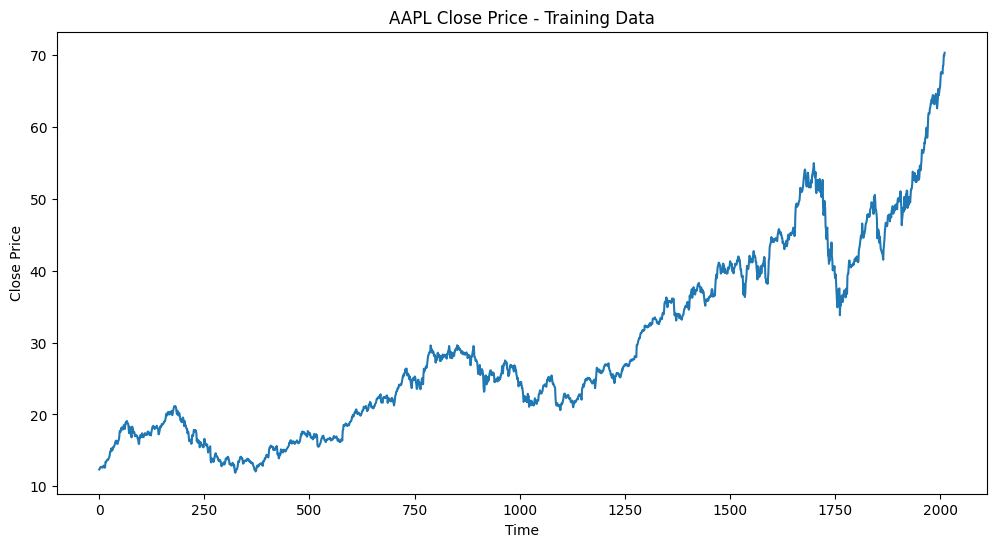

In [50]:
#Plot showing the close price during training period
plt.figure(figsize=(12, 6))
plt.plot(df_train['Close'])
plt.title('AAPL Close Price - Training Data')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.show()
# This plot shows the closing price of AAPL during the training period.

In [51]:

from gym_anytrading.envs import StocksEnv
import numpy as np
import pandas as pd

class RiskawareStocksEnv(StocksEnv):
  def __init__(self, df, window_size=60, frame_bound=None, transaction_cost=0.0006):
    self.custom_cost = transaction_cost
    self.previous_position = 0
    super().__init__(df, window_size, frame_bound)

  def calculate_reward(self, action):
      action_to_position = {0: -1, 1: 0, 2: 1}
      a = action_to_position[action]
      previous_a = self.previous_position
      t = self._current_tick
      if t <= self.window_size:
         self.previous_position = a  # #No rewards until indicators are reliable
         return 0.0
      #price change
      ret = self.prices[t] - self.prices[t-1]
      #volatility from past data
      vol_data = pd.Series(self.prices[:t]).pct_change().rolling(30).std()
      vol = vol_data.iloc[-1] if not vol_data.empty else 1e-3
      vol = float(vol) if pd.notna(vol) and vol > 1e-8 else 1e-3
      #scaled reward
      scaled = (a * ret) / vol
      cost = self.custom_cost * abs(a - previous_a) * self.prices[t-1] #transaction cost based on yesterday price
      self.previous_position = a # Update position after calculating reward
      return float(scaled - cost)

  #Let the original environment advance one step
  def step(self, action):
     obs, _, terminated, truncated, info = super().step(action)
     reward = self.calculate_reward(action)
     return obs, reward, terminated, truncated, info

  def _process_data(self):
     prices = self.df[('Price', 'Close')].values
     signal_features = np.column_stack([
         self.df[('Price', 'Close')].pct_change().fillna(0.0).values,
         self.df[('Price', 'Close')].rolling(20).mean().bfill().values,
         self.df[('Price', 'Close')].rolling(50).mean().bfill().values,
         self.df[('Price', 'Close')].rolling(20).std().bfill().values,
     ])
     return prices, signal_features


In [52]:
print(df_train.columns)


MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [53]:
def make_ohlcv_single_index(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # If columns are MultiIndex, flatten them
    if isinstance(df.columns, pd.MultiIndex):
        # Common yfinance styles:
        # ('Price','Close') or ('Close','AAPL') etc.
        # We'll keep only the last level name as the column label when possible.
        df.columns = [c[-1] for c in df.columns]

    # Sometimes columns become duplicated after flattening; keep first occurrence
    df = df.loc[:, ~pd.Index(df.columns).duplicated()]

    # Now ensure we have a "Close" column
    if "Close" not in df.columns:
        # Try common alternatives
        candidates = [c for c in df.columns if str(c).lower() in ["close", "adj close", "adjclose", "price"]]
        if candidates:
            df = df.rename(columns={candidates[0]: "Close"})
        else:
            raise KeyError(f"Could not find a Close-like column. Columns are: {list(df.columns)}")

    # Ensure numeric Close
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    df = df.dropna(subset=["Close"]).reset_index(drop=True)

    return df


In [54]:
import pandas as pd
import numpy as np

def make_close_df(df: pd.DataFrame, ticker: str = "AAPL") -> pd.DataFrame:
    df = df.copy()

    # Case C: MultiIndex columns (common from yfinance)
    if isinstance(df.columns, pd.MultiIndex):
        # Try: ('Close', ticker) or ('Price','Close') etc.
        if ("Close", ticker) in df.columns:
            close = df[("Close", ticker)]
        elif ("Adj Close", ticker) in df.columns:
            close = df[("Adj Close", ticker)]
        elif ("Price", "Close") in df.columns:
            close = df[("Price", "Close")]
        else:
            # fallback: try any column whose last level is 'Close'
            close_candidates = [c for c in df.columns if c[-1] == "Close"]
            if close_candidates:
                close = df[close_candidates[0]]
            else:
                raise KeyError(f"MultiIndex df but couldn't find Close. Columns: {df.columns.tolist()}")
        out = pd.DataFrame({"Close": close})

    else:
        # Case A: single column named by ticker
        if df.shape[1] == 1 and df.columns[0] == ticker:
            out = df.rename(columns={ticker: "Close"})[["Close"]]

        # Case B: already has Close
        elif "Close" in df.columns:
            out = df[["Close"]].copy()

        # Adj Close fallback
        elif "Adj Close" in df.columns:
            out = df.rename(columns={"Adj Close": "Close"})[["Close"]]

        else:
            raise KeyError(f"Could not find Close-like column. Columns are: {list(df.columns)}")

    # Clean
    out["Close"] = pd.to_numeric(out["Close"], errors="coerce")
    out = out.dropna(subset=["Close"]).reset_index(drop=True)

    return out


In [55]:
df_train_clean = make_close_df(df_train, ticker="AAPL")
df_val_clean   = make_close_df(df_val, ticker="AAPL")
df_test_clean  = make_close_df(df_test, ticker="AAPL")

print(df_train_clean.head())
print(df_train_clean.columns)


       Close
0  12.333214
1  12.399494
2  12.537153
3  12.668215
4  12.648123
Index(['Close'], dtype='object')


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [60]:
# Transform df_train_clean to match the MultiIndex format expected by RiskawareStocksEnv
df_train_for_env = pd.DataFrame(df_train_clean['Close'])
df_train_for_env.columns = pd.MultiIndex.from_tuples([('Price', 'Close')])

env_train = RiskawareStocksEnv(
    df=df_train_for_env, # Pass the transformed DataFrame
    window_size=60,
    frame_bound=(60, len(df_train_clean)),
    transaction_cost=0.001
)

# Also prepare validation and test dataframes for consistency, though not directly used in this cell.
# Transform df_val_clean to match the MultiIndex format expected by RiskawareStocksEnv
df_val_for_env = pd.DataFrame(df_val_clean['Close'])
df_val_for_env.columns = pd.MultiIndex.from_tuples([('Price', 'Close')])

# Transform df_test_clean to match the MultiIndex format expected by RiskawareStocksEnv
df_test_for_env = pd.DataFrame(df_test_clean['Close'])
df_test_for_env.columns = pd.MultiIndex.from_tuples([('Price', 'Close')])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [57]:
from stable_baselines3.common.vec_env import DummyVecEnv
env = DummyVecEnv([lambda: env_train])


In [58]:
from stable_baselines3 import PPO

model_ppo = PPO(
    policy="MlpPolicy",
    env=env,
    verbose=1,
    seed=42,
    tensorboard_log="./ppo_tensorboard/",
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    gamma=0.99
)

model_ppo.learn(total_timesteps=100_000, tb_log_name="ppo_riskaware_trading")
model_ppo.save("rl_trading_agent_ppo")


Using cpu device
Logging to ./ppo_tensorboard/ppo_riskaware_trading_2
-----------------------------
| time/              |      |
|    fps             | 415  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 299         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013963262 |
|    clip_fraction        | 0.0464      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.68       |
|    explained_variance   | 8.92e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.74e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | 0.000461    |
|    value_loss           | 4.65e+03    |
------

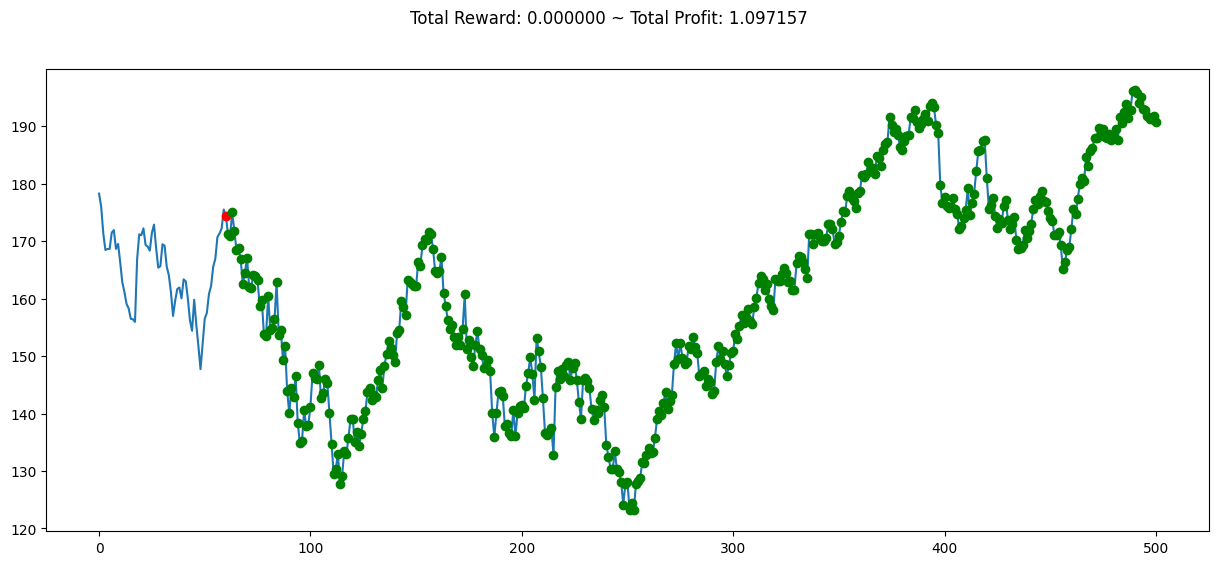


--- Test Results (PPO) ---
Final Sharpe Ratio: 0.7576
Maximum Drawdown (MDD): 0.0000
Total Profit (Equity End): 1.0972


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Build TEST environment
# -----------------------------
test_env = RiskawareStocksEnv(
    df=df_test_for_env.copy(),                 # use CLEAN df with column "Close"
    window_size=60,
    frame_bound=(60, len(df_test_clean)),
    transaction_cost=0.0006
)

# -----------------------------
# 2) Run trained PPO on test set
# -----------------------------
obs, info = test_env.reset()
terminated, truncated = False, False

while not (terminated or truncated):
    # SB3 model expects shape (n_envs, obs_dim) even for one env
    obs_input = np.expand_dims(obs, axis=0)

    action, _ = model_ppo.predict(obs_input, deterministic=True)
    action = int(action[0])  # convert array([x]) -> x

    obs, reward, terminated, truncated, info = test_env.step(action)

# -----------------------------
# 3) Plot equity curve from gym-anytrading renderer
# -----------------------------
plt.figure(figsize=(15, 6))
test_env.render_all()
plt.show()

# -----------------------------
# 4) Extract equity curve + metrics
# -----------------------------
history = test_env.unwrapped.history

# gym-anytrading usually stores 'total_profit' (profit ratio over time)
if "total_profit" not in history:
    raise KeyError(f"'total_profit' not found. Available history keys: {list(history.keys())}")

equity_curve = np.array(history["total_profit"], dtype=float)

# If your total_profit starts from 0 instead of 1, uncomment:
# equity_curve = equity_curve + 1.0

returns = pd.Series(equity_curve).pct_change().dropna()

final_sharpe = sharpe_ratio(returns)
final_mdd = max_drawdown(equity_curve)
total_profit = float(equity_curve[-1])

print("\n--- Test Results (PPO) ---")
print(f"Final Sharpe Ratio: {final_sharpe:.4f}")
print(f"Maximum Drawdown (MDD): {final_mdd:.4f}")
print(f"Total Profit (Equity End): {total_profit:.4f}")